<a href="https://colab.research.google.com/github/achalweise/sales-predictions/blob/main/Sales_Prediction_Part_5_(ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

filename = '/content/sales_predictions (1).csv'

df_sales_prediction =pd.read_csv(filename)
df_sales_prediction.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


1) How many rows and columns?



In [22]:
df_sales_prediction.shape

(8523, 12)

2) What are the datatypes of each variable?



In [23]:
df_sales_prediction.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

3) Are there duplicates? If so, drop any duplicates.


In [24]:
df_sales_prediction.duplicated().any() #no duplicates 

False

4) Identify missing values.


In [25]:
df_sales_prediction.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

5) Decide on how to address the missing values and do it! (This requires your judgement, so explain your choice).

In [26]:
#Drop Item_Weight and Outlet_Size, enough missing data to remove columns
df_sales_prediction.drop(columns = ['Item_Weight', 'Outlet_Size'], inplace = True)

6) Confirm that there are no missing values after addressing them.

In [27]:
df_sales_prediction.isna().sum() # columns removed 


Item_Identifier              0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

7) Find and fix any inconsistent categories of data (example: fix cat, Cat, and cats so that they are consistent) 

In [28]:
#Item Fat Content Clean Up
df_sales_prediction['Item_Fat_Content'].value_counts()
df_sales_prediction.replace(['LF', 'Low Fat'],  inplace = True)
df_sales_prediction.replace(['reg', 'Regular'], inplace = True)
df_sales_prediction.replace(['low fat','Low Fat'], inplace = True)
df_sales_prediction['Item_Fat_Content'].value_counts()
df_sales_prediction.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Tier 1,Supermarket Type1,3735.1380
1,DRC01,Low Fat,0.019278,Soft Drinks,48.2692,OUT018,2009,Tier 3,Supermarket Type2,443.4228
2,FDN15,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Tier 1,Supermarket Type1,2097.2700
3,FDX07,Low Fat,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Tier 3,Grocery Store,732.3800
4,NCD19,Low Fat,0.000000,Household,53.8614,OUT013,1987,Tier 3,Supermarket Type1,994.7052


In [29]:
df_sales_prediction['Item_Type'].value_counts()
df_sales_prediction['Outlet_Identifier'].value_counts()
df_sales_prediction['Outlet_Establishment_Year'].value_counts()
df_sales_prediction['Outlet_Location_Type'].value_counts()
df_sales_prediction['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

8) For any numerical columns, obtain the summary statistics of each (min, max, mean)

In [30]:
df_sales_prediction.describe()

,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,0.066132,140.992782,1997.831867,2181.288914
std,0.051598,62.275067,8.371760,1706.499616
min,0.000000,31.290000,1985.000000,33.290000
25%,0.026989,93.826500,1987.000000,834.247400
50%,0.053931,143.012800,1999.000000,1794.331000
75%,0.094585,185.643700,2004.000000,3101.296400
max,0.328391,266.888400,2009.000000,13086.964800


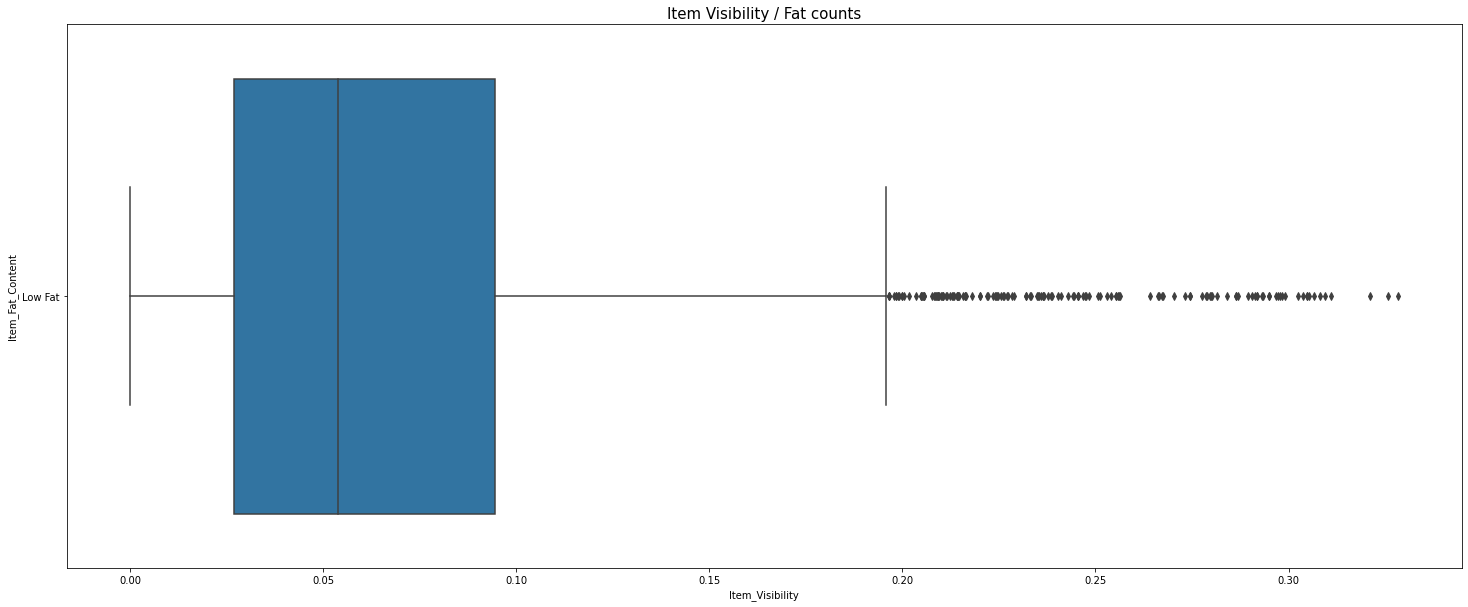

In [31]:
plt.figure(figsize=(25, 10))
sns.boxplot(x = df_sales_prediction['Item_Visibility'], y = df_sales_prediction['Item_Fat_Content'])
plt.title('Item Visibility / Fat counts', fontsize = 15);

#Low Fat and Regular fat content items have about the same level of visbility 


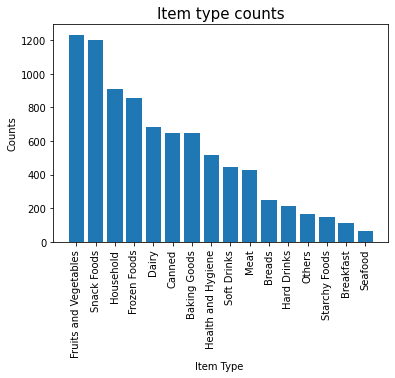

In [32]:
item_type = df_sales_prediction['Item_Type'].value_counts()
item_fat_content = df_sales_prediction['Item_Fat_Content'].value_counts()
plt.bar(item_type.index, item_type.values)
plt.xticks(rotation=90)
plt.title('Item type counts', fontsize = 15)
plt.xlabel('Item Type ', fontsize = 10)
plt.ylabel('Counts', fontsize = 10);

#snack foods are primarly regular in fat content and fruits and veggies are low in fat content, 
#this means both snacks ( regular fat content) and fruits and veggies ( low fat content) 
#are equally promoted within supermarkets. 


In [33]:
low_fat = df_sales_prediction['Item_Fat_Content'] == "Low Fat"
low_fat.value_counts()

True    8523
Name: Item_Fat_Content, dtype: int64

In [34]:
regular = df_sales_prediction['Item_Fat_Content'] == "Regular"
regular.value_counts()

False    8523
Name: Item_Fat_Content, dtype: int64

In [35]:
#Identify the target (X) and features (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the
# relevant variables as your features matrix.  

X = df_sales_prediction.drop(columns='Item_Outlet_Sales')
y = df_sales_prediction['Item_Outlet_Sales']

In [36]:
#Perform a train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [44]:
#Create a pre processing pipeline to prepare the dataset for Machine Learning

# instantiate the column selectors
category_selector = make_column_selector(dtype_include='object')
numeric_selector = make_column_selector(dtype_include='number')

#instantiate the encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()
num_tuple = (scaler, numeric_selector)
cat_tuple = (encoder, category_selector)

col_trans = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')

#Instantiate Linear Regression Model
lin_reg = LinearRegression()

pipe = make_pipeline(col_trans, lin_reg)


In [39]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa328964390>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3289640d0>)])),
                ('linearregression', LinearRegression())])